<a href="https://colab.research.google.com/github/ShahViraj11/Plan-Leaf-Disease-Detection/blob/main/tomatodisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow keras
import tensorflow as tf
import pandas as pd
from google.colab import auth
import os
import shutil
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 443.2/644.9 MB 36.5 MB/s eta 0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.8 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 390747786ac979809fa1cfcf6916220ef0bfed6b9e1b8c643b6b09184a868fe4
             Got        0922803b7310eb03722c1d040c37dcad4f29338049d372b24eab8bbbffd5fc9c



In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
#move LeavesDataset.zip to content and unzip
!cp /content/drive/MyDrive/LeavesDataset.zip /content/
!unzip /content/LeavesDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: LeavesDataset/PotatoDataset/potato_healthy/b536ea91-c5f8-413b-87f3-a22ac3d959d1___RS_HL 1825.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/b61b9d33-59ea-41b0-a554-c382eb6128c5___RS_HL 1919.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/b89db9d3-a413-4781-bc88-5f6c2085ab5f___RS_HL 1909.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/b8b7b98a-eb1a-4213-9b0b-aeef4df427e8___RS_HL 1858.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/b925ad3e-fc49-497d-a6eb-115f0de20800___RS_HL 4170.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/b9ea902d-e557-4fa5-893b-39a7a57c0121___RS_HL 1893.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/bb04f738-1848-4dda-8834-384a48b335cd___RS_HL 1765.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healthy/bb328d40-e4e6-4b84-a92a-e7cb3922c19d___RS_HL 1829.JPG  
  inflating: LeavesDataset/PotatoDataset/potato_healt

In [4]:
#print folder names within LeavesDataset
!ls /content/LeavesDataset

PotatoDataset  TomatoDataset


In [6]:


# Define base dataset directory
base_dir = "/content/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# List Potato and Tomato
plants = ["PotatoDataset", "TomatoDataset"]

potato_classes = ['potato_early_blight', 'potato_healthy', 'potato_late_blight']
tomato_classes = ['Tomato_bacterial_spot', 'Tomato_healthy', 'Tomato_leaf_mold',
                  'Tomato_septoria_leaf_spot']

classes = potato_classes + tomato_classes

plant_dict = {
    "PotatoDataset": potato_classes,
    "TomatoDataset": tomato_classes
}

# Create train, val, test directories for each class
for folder in classes:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

# Function to split data
def split_data(source, train_dest, val_dest, test_dest, train_size=0.7, val_size=0.15):
    images = os.listdir(source)
    random.shuffle(images)

    train_split = int(len(images) * train_size)
    val_split = int(len(images) * (train_size + val_size))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(source, img), os.path.join(train_dest, img))
    for img in val_images:
        shutil.copy(os.path.join(source, img), os.path.join(val_dest, img))
    for img in test_images:
        shutil.copy(os.path.join(source, img), os.path.join(test_dest, img))

# Apply the split to all classes
for plant in plants:
  for category in plant_dict[plant]:
    source_dir = f"/content/LeavesDataset/{plant}/{category}"
    split_data(source_dir, f"{train_dir}/{category}", f"{val_dir}/{category}", f"{test_dir}/{category}")



In [7]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(224, 224), batch_size=32, shuffle=True, label_mode="int"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=(224, 224), batch_size=32, shuffle=True, label_mode="int"
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(224, 224), batch_size=32, shuffle=True,  label_mode="int"
)

# Check class names
print(train_ds.class_names)

Found 4272 files belonging to 7 classes.
Found 916 files belonging to 7 classes.
Found 916 files belonging to 7 classes.
['Tomato_bacterial_spot', 'Tomato_healthy', 'Tomato_leaf_mold', 'Tomato_septoria_leaf_spot', 'potato_early_blight', 'potato_healthy', 'potato_late_blight']


In [8]:
#get input shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [9]:


# Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
])



# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - accuracy: 0.5603 - loss: 1.2094 - val_accuracy: 0.8177 - val_loss: 0.5764
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7889 - loss: 0.5873 - val_accuracy: 0.8177 - val_loss: 0.4850
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8368 - loss: 0.4667 - val_accuracy: 0.8712 - val_loss: 0.3939
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8581 - loss: 0.4042 - val_accuracy: 0.8788 - val_loss: 0.3460
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8857 - loss: 0.3252 - val_accuracy: 0.8952 - val_loss: 0.3070
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8920 - loss: 0.2988 - val_accuracy: 0.8766 - val_loss: 0.3533
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9011 - loss: 0.2794 - val_accuracy: 0.8985 - val_loss: 0.2800
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45

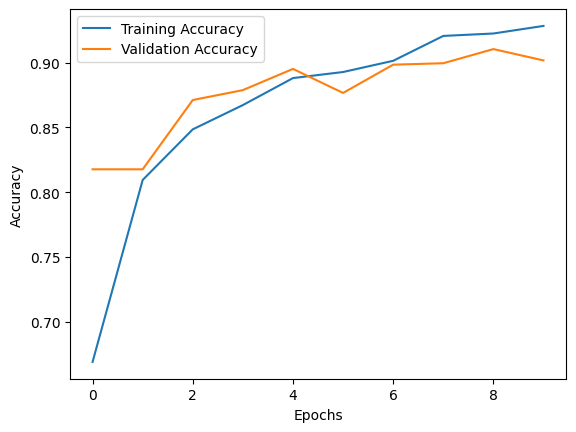

<Figure size 640x480 with 0 Axes>

In [10]:
#epoch training and validation accuracy graph

history_dict = history.history

plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('accuracy.png')

In [11]:
#test model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8864 - loss: 0.2747
Test accuracy: 0.8984715938568115


In [13]:
# Get the true labels and predictions in a more reliable way
true_labels = []
all_predictions = []

# Iterate through the test dataset batch by batch
for images, labels in test_ds:
    # Get predictions for this batch
    batch_predictions = model.predict(images)
    batch_predictions = tf.argmax(batch_predictions, axis=1)

    # Append to our lists
    true_labels.extend(labels.numpy())
    all_predictions.extend(batch_predictions.numpy())

# Now calculate accuracy

#print num of unique values in true_labels
print(true_labels)
print(set(true_labels))

accuracy = accuracy_score(true_labels, all_predictions)
print(f"Accuracy: {accuracy}")

# And generate a classification report

print(classification_report(true_labels, all_predictions, target_names=classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/s

<Axes: >

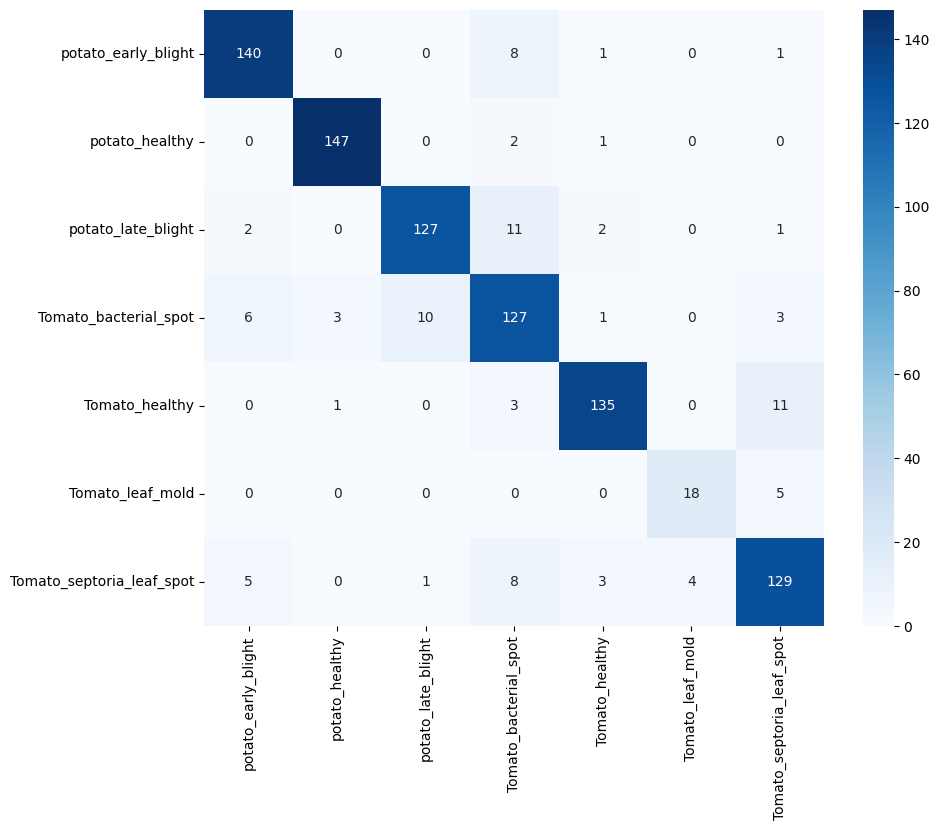

In [14]:
#output confusion matrix
cm = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)